In [1]:
import os
import glob
import datetime
import statistics
import numpy as np
import pandas as pd
from marcap import marcap_data
import FinanceDataReader as fdr
import matplotlib.pyplot as plt

|종목 수|시가총액 하위(%)|기간|리밸런싱|CAGRR|IFRS|CFS|NOTE|
|-----|-------|-------|-----|-----|----|---|-|
| 30 | 20 | 2002 ~ 2019 |8/1| 1.426987 |1|0, 1| |
| 30 | 20 | 2002 ~ 2019 |10/1| 1.462075 |1|0, 1| |

In [98]:
NUM_STOCKS = 30
DATA_DIR = 'data/daily/10-1'
MIN_MARKET_CAP = 0.0
MAX_MARKET_CAP = 0.2
BLACK_NAMES = ['보험', '화재', '금융', '홀딩스', '신용', '증권', '생명', '스팩']

In [99]:
df_account = pd.DataFrame(columns=['start_date', 'end_date', 'filepath'])
filepaths = glob.glob(DATA_DIR + "/*.csv")
filepaths = sorted(filepaths)

days = []
for i in range(len(filepaths)):
    if i < len(filepaths) - 1: # exclude last item
        start_date =  os.path.basename(filepaths[i])[:-4]
        end_date =  os.path.basename(filepaths[i + 1])[:-4]
        
        day = {'start_date':start_date, 'end_date':end_date, 'filepath':filepaths[i]}
        days.append(day)

df_account = df_account.append(days)

In [100]:
df_account

,start_date,end_date,filepath
0,2002-10-01,2003-10-01,data/daily/10-1/2002-10-01.csv
1,2003-10-01,2004-10-01,data/daily/10-1/2003-10-01.csv
2,2004-10-01,2005-10-03,data/daily/10-1/2004-10-01.csv
3,2005-10-03,2006-10-02,data/daily/10-1/2005-10-03.csv
4,2006-10-02,2007-10-01,data/daily/10-1/2006-10-02.csv
5,2007-10-01,2008-10-01,data/daily/10-1/2007-10-01.csv
6,2008-10-01,2009-10-01,data/daily/10-1/2008-10-01.csv
7,2009-10-01,2010-10-01,data/daily/10-1/2009-10-01.csv
8,2010-10-01,2011-10-03,data/daily/10-1/2010-10-01.csv
9,2011-10-03,2012-10-01,data/daily/10-1/2011-10-03.csv


In [101]:
def exclude_holdings_and_finances(df, col):    
    def corp_name_has_black(corp_name):
        for black_name in BLACK_NAMES:
            if black_name in corp_name:
                return True
        return False
        
    df['black'] = df.apply(lambda x: corp_name_has_black(x[col]), axis=1)
    df = df[df['black'] == False]
    return df

def exclude_foreign_corps(df, col):
    df['foreign'] = df.apply(lambda x: x[col][0] == '9', axis=1)
    df = df[df['foreign'] == False]
    return df

def exclude_minus_income_corps(df, cols):
    df['plus'] = True
    for col in cols:
        df[col] = df[col].fillna(0) # 당기순이익이 없는 경우 플러스로 만들기 위해 0으로 넣어줌
        df['plus'] = (df[col] >= 0) * df['plus']
    
    df = df[df['plus'] == True]
    return df

In [102]:
def get_stocks(filepath, date):
    print("------------------------------")
    print(date, filepath)
    df = pd.read_csv(filepath, dtype={"기업코드":"string", "종목코드":"string"})
    
#     past_income_cols = []
#     last_year = int(date[:4]) - 1
#     for i in range(1, 6):
#         year = last_year - i
#         col_name = str(year) + '-' + '당기순이익'
#         past_income_cols.append(col_name)
        
    cols = ['종목코드', 'IFRS', 'CFS', '회사명', '시가총액', 'PBR', 'GP/A', '당기순이익']
    #cols.extend(past_income_cols)

    df_qp = df[cols]
    print('전체', len(df_qp))
    
    # 지주사, 금융사 제외
    df_qp = exclude_holdings_and_finances(df_qp, '회사명')
    print('지주사, 금융사 제외', len(df_qp))
    
    # 국외주식 제외
    df_qp = exclude_foreign_corps(df_qp, '종목코드')
    print('국외주식 제외', len(df_qp))
    
    # 당기순이익 최근 5년 +인것만
    #df_qp = exclude_minus_income_corps(df_qp, past_income_cols)
    
    # 전년도 당기순이익 +인것만
    # df_qp = df_qp[df_qp['당기순이익'] > 0]
    
    # 시가총액 하위 20% 
    #df_qp = df_qp[(df_qp['IFRS'] == 1) & (df_qp['CFS'] == 1)] # 국제회계기준 + 연결재무제표 기업만
    df_qp = df_qp[df_qp['시가총액'] > 0] # 시가총액 data가 없는 row는 제거
    df_qp = df_qp.sort_values(by=['시가총액'])
    print('가격정보 없는 기업 제외', len(df_qp))
    df_qp = df_qp[int(len(df_qp)*MIN_MARKET_CAP):int(len(df_qp)*MAX_MARKET_CAP)]
    
    df_qp = df_qp[df_qp['PBR'] > 0]
    
    # get ranks
    df_qp['1/PBR'] = 1 / df_qp['PBR']
    df_qp['RANK_1'] = df_qp['1/PBR'].rank(ascending=False)
    df_qp['RANK_2'] = df_qp['GP/A'].rank(ascending=False)
    
    df_qp['TOTAL_RANK'] = df_qp['RANK_1'] + df_qp['RANK_2']

    df_qp = df_qp.sort_values(by=['TOTAL_RANK'])    
    
    stocks = []
    counter = 0
    for i, row in df_qp.iterrows():
        counter += 1
        if counter > NUM_STOCKS:
            break
        
        candidate = row['종목코드']
        candidate_name = row['회사명']
            
        #print(candidate_name, row['TOTAL_RANK'])
        stocks.append(candidate)
    
    print("선정 기업 수", len(stocks))
    return stocks

In [103]:
# get_stocks('data/daily/8-1/2018-08-01.csv', '2018-08-01')

In [104]:
df_account['stocks'] = df_account.apply(lambda x: get_stocks(x.filepath, x.start_date), axis=1)

------------------------------
2002-10-01 data/daily/10-1/2002-10-01.csv
전체 1480
지주사, 금융사 제외 1384


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


국외주식 제외 1384
가격정보 없는 기업 제외 998
선정 기업 수 30
------------------------------
2003-10-01 data/daily/10-1/2003-10-01.csv
전체 1569
지주사, 금융사 제외 1472
국외주식 제외 1472
가격정보 없는 기업 제외 1055
선정 기업 수 30
------------------------------
2004-10-01 data/daily/10-1/2004-10-01.csv
전체 1619
지주사, 금융사 제외 1519
국외주식 제외 1519
가격정보 없는 기업 제외 1105
선정 기업 수 30
------------------------------
2005-10-03 data/daily/10-1/2005-10-03.csv
전체 1710
지주사, 금융사 제외 1609
국외주식 제외 1608
가격정보 없는 기업 제외 1162
선정 기업 수 30
------------------------------
2006-10-02 data/daily/10-1/2006-10-02.csv
전체 1762
지주사, 금융사 제외 1658
국외주식 제외 1657
가격정보 없는 기업 제외 1223
선정 기업 수 30
------------------------------
2007-10-01 data/daily/10-1/2007-10-01.csv
전체 1846
지주사, 금융사 제외 1738
국외주식 제외 1733
가격정보 없는 기업 제외 1295
선정 기업 수 30
------------------------------
2008-10-01 data/daily/10-1/2008-10-01.csv
전체 1933
지주사, 금융사 제외 1820
국외주식 제외 1811
가격정보 없는 기업 제외 1367
선정 기업 수 30
------------------------------
2009-10-01 data/daily/10-1/2009-10-01.csv
전체 1982
지주사, 금융사 제외 1865
국외주식 제외 1850
가

In [106]:
# 연도별 수익률을 구한다.
df_account['yield'] = 0.0
df_account['yields'] = 0.0
df_account['yields'] = df_account['yields'].astype('object')

for i in range(len(filepaths)):
    if i < len(filepaths) - 1: # exclude last item
        start_date = df_account.iloc[i].start_date
        end_date = df_account.iloc[i].end_date
        
        df_this_year = pd.read_csv(filepaths[i], dtype={"기업코드":"string", "종목코드":"string"})[['종목코드', '주가']]
        df_next_year = pd.read_csv(filepaths[i + 1], dtype={"기업코드":"string", "종목코드":"string"})[['종목코드', '주가']]
        
        stocks = df_account.iloc[i].stocks   
        yields = []
        
        # 종목별 수익률을 구한다.
        for stock in stocks:
            start_price = df_this_year[df_this_year['종목코드'] == stock]['주가'].iloc[0]
            end_price = df_next_year[df_next_year['종목코드'] == stock]['주가']
            
            if len(end_price) == 0:
                end_price = 0
            else:                    
                end_price = end_price.fillna(0) # 가격 정보가 없을 경우 상폐
                end_price = end_price.iloc[0]
            
            # get yield
            yields.append(end_price / start_price)

        # stock 수익률들의 avg가 total 수익률이 된다. (동일 비중이기 때문에)
        mean_yields = statistics.mean(yields)
        df_account.at[i, 'yield'] = mean_yields
        df_account.at[i, 'yields'] = yields
        
        print(start_date, '~', end_date, ":", mean_yields)
        
        #break

2002-10-01 ~ 2003-10-01 : 0.9657081324754272
2003-10-01 ~ 2004-10-01 : 1.3158677110903145
2004-10-01 ~ 2005-10-03 : 2.362608036885164
2005-10-03 ~ 2006-10-02 : 1.2012778150006713
2006-10-02 ~ 2007-10-01 : 2.6491153739948716
2007-10-01 ~ 2008-10-01 : 0.7632397281592082
2008-10-01 ~ 2009-10-01 : 1.3310008766826664
2009-10-01 ~ 2010-10-01 : 1.2954113066687143
2010-10-01 ~ 2011-10-03 : 1.698875907954822
2011-10-03 ~ 2012-10-01 : 2.3350098900885317
2012-10-01 ~ 2013-10-01 : 1.0852891939109162
2013-10-01 ~ 2014-10-01 : 1.450367413061092
2014-10-01 ~ 2015-10-01 : 1.7114807242754462
2015-10-01 ~ 2016-10-03 : 1.5180537184871457


In [107]:
df_account['total'] = df_account['yield'].cumprod()

In [108]:
df_account['cagr'] = 0.0
for i, row in enumerate(df_account.iterrows()):
    df_account.at[i, 'cagr'] = pow(row[1]['total'], 1/(i+1))

In [109]:
def get_win_rate(yield_rates):
    return sum([yield_rate > 1.0 for yield_rate in yield_rates]) / len(yield_rates)

df_account['win_rate'] = df_account.apply(lambda x: get_win_rate(x['yields']), axis=1)

In [110]:
df_account['best_corp'] = df_account.apply(lambda x: max(x['yields']), axis=1)
df_account['worst_corp'] = df_account.apply(lambda x: min(x['yields']), axis=1)

In [111]:
df_account['best_stock_code'] = df_account.apply(lambda x: x['stocks'][np.argmax(x['yields'])], axis=1)
df_account['worst_stock_code'] = df_account.apply(lambda x: x['stocks'][np.argmin(x['yields'])], axis=1)

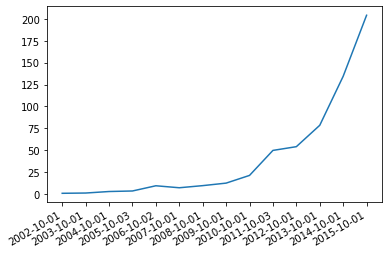

In [112]:
fig, ax = plt.subplots()
ax.plot_date(df_account['start_date'], df_account['total'], marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

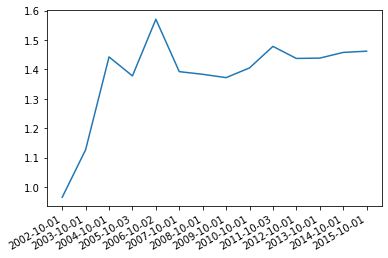

In [113]:
fig, ax = plt.subplots()
ax.plot_date(df_account['start_date'], df_account['cagr'], marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

In [114]:
df_account

,start_date,end_date,filepath,stocks,yield,yields,total,cagr,win_rate,best_corp,worst_corp,best_stock_code,worst_stock_code
0,2002-10-01,2003-10-01,data/daily/10-1/2002-10-01.csv,"[027040, 010600, 008900, 003230, 025880, 04106...",0.965708,"[3.8620689655172415, 0.7952286282306164, 0.352...",0.965708,0.965708,0.166667,3.862069,0.352381,027040,008900
1,2003-10-01,2004-10-01,data/daily/10-1/2003-10-01.csv,"[010600, 014100, 003680, 002140, 016920, 02588...",1.315868,"[0.91375, 0.9012345679012346, 2.51800554016620...",1.270744,1.127273,0.400000,9.436620,0.456250,006090,032860
2,2004-10-01,2005-10-03,data/daily/10-1/2004-10-01.csv,"[010600, 017680, 032860, 005320, 038010, 01410...",2.362608,"[1.4582763337893296, 2.1522842639593907, 3.630...",3.002270,1.442613,1.000000,6.958904,1.158537,014100,038320
3,2005-10-03,2006-10-02,data/daily/10-1/2005-10-03.csv,"[010600, 046310, 007980, 005320, 045060, 01420...",1.201278,"[2.682926829268293, 1.3971830985915492, 1.1788...",3.606561,1.378076,0.633333,2.682927,0.135505,010600,014570
4,2006-10-02,2007-10-01,data/daily/10-1/2006-10-02.csv,"[068290, 007980, 025880, 000440, 016920, 00811...",2.649115,"[1.6601123595505618, 2.025065963060686, 2.0370...",9.554196,1.570503,1.000000,13.856749,1.043011,004090,024940
5,2007-10-01,2008-10-01,data/daily/10-1/2007-10-01.csv,"[017680, 078520, 068290, 010600, 038320, 00606...",0.763240,"[0.5650969529085873, 0.6543478260869565, 0.079...",7.292142,1.392545,0.166667,2.382979,0.079357,009470,068290
6,2008-10-01,2009-10-01,data/daily/10-1/2008-10-01.csv,"[038320, 011080, 005320, 088790, 046310, 07195...",1.331001,"[2.4871794871794872, 0.7619047619047619, 0.943...",9.705847,1.383582,0.666667,4.012712,0.676768,079190,043220
7,2009-10-01,2010-10-01,data/daily/10-1/2009-10-01.csv,"[038320, 011080, 033340, 017680, 010470, 01447...",1.295411,"[0.27319587628865977, 0.8541666666666666, 0.96...",12.573064,1.372240,0.733333,3.181818,0.000000,033280,014470
8,2010-10-01,2011-10-03,data/daily/10-1/2010-10-01.csv,"[011080, 033340, 032860, 038320, 011090, 08879...",1.698876,"[0.7268292682926829, 0.9333333333333333, 17.51...",21.360075,1.405185,0.400000,17.516129,0.074403,032860,024940
9,2011-10-03,2012-10-01,data/daily/10-1/2011-10-03.csv,"[011080, 038320, 046310, 091440, 056000, 07195...",2.335010,"[2.248322147651007, 0.0, 1.3843416370106763, 2...",49.875987,1.478390,0.933333,14.734043,0.000000,010600,038320


In [ ]:
# df_account.to_csv('backtest-output/' + DATA_DIR + '.csv', index=False)